<h1> Relax Data Science Challenge </h1>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

<h2> Data Import </h2>

In [2]:
users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


<h2> General Exploring & Cleaning </h2>

<b> Make Sure Ids are Unique </b>

In [4]:
(users.object_id.value_counts() > 1).sum()

0

<b> Make '*creation_time' Columns DateTime </b>

In [5]:
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')
users.creation_time = pd.to_datetime(users.creation_time)

In [6]:
users.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object

<b> Any Missing Values? </b>

In [7]:
users.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

About half the people were not invited by someone and a quarter of them haven't logged into the system. <b> What is the most recent log in time out of all the users? </b>

In [8]:
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [9]:
engagement.time_stamp.min(), engagement.time_stamp.max()

(Timestamp('2012-05-31 08:20:06'), Timestamp('2014-06-06 14:58:50'))

The most recent login was June 6, 2014 so we will set today's date to June 6, 2014.

In [10]:
today = engagement.time_stamp.max()

Add a column that measures the time since a users last session as compared to the most recent session called 'time_from_last_session'

In [11]:
users['days_since_last_session'] = today - users.last_session_creation_time
users['days_since_last_session'] = users.days_since_last_session.apply(lambda x: x.days)

In [12]:
users['user_age_days'] = today - users.creation_time
users['user_age_days'] = users.user_age_days.apply(lambda x: x.days)

<h3> New Features </h3>
<ol>
    <li> median_between_login_time : The median of all the differences between consecutive logins. NaN if the user never logged in after the creation </li>
    <li> first_login_after_creation : The first login after the creation of the account. Also NaN if the user never logged in after the creation </li>
    <li> first_month_visits: The number of logins in the first month of the account creation (the creation itself counts as 1). </li>
</ol>

In [13]:
user_ids = list(engagement.user_id.unique())

In [14]:
def calculate_login_metrics(user_id):
    """Finds the median time between a user's logins and the time between the initial creation and the first login"""
    temp = engagement[engagement.user_id==user_id].sort_values(by='time_stamp')

    # Calculate the time between each of the users login (in days)
    temp['between_login'] = temp.time_stamp.diff()
    median_between_login_time = temp.between_login.median().days
    
    # Find the length of time it took a user to login after the creation (in days)
    try:
        first_login_after_creation = temp.iloc[1,3]
    except IndexError:
        first_login_after_creation = np.nan

    # Find the number of visits in the first month of creating the account (account creation counts as 1)
    first_month = temp.iloc[0,0] + datetime.timedelta(days=30)
    first_month_visits = temp[temp.time_stamp <= first_month].visited.sum()
    
    return median_between_login_time, first_login_after_creation, first_month_visits

In [15]:
medianlst = []
firstlst = []
first_visits_lst = []

for user_id in user_ids:
    median, login, visits = calculate_login_metrics(user_id)
    medianlst.append(median)
    firstlst.append(login)
    first_visits_lst.append(visits)

C:\Users\monke\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\monke\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\monke\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\monke\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\monke\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\monke\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke

In [16]:
df = pd.DataFrame(list(zip(user_ids, medianlst, firstlst, first_visits_lst)),
                  columns = ['user_id', 'median_between_login_time','first_login_after_creation_days', 'first_month_visits'])

In [17]:
users = users.merge(df,left_on='object_id', right_on='user_id',how='left')
users.drop(columns=['user_id'], inplace=True)
users['first_login_after_creation_days'] = users.first_login_after_creation_days.apply(lambda x: x.days)

<h2> Creating the Adopted User Column </h2>

In [18]:
def is_user_adopted(user_id):    
    temp = engagement[engagement.user_id==user_id].sort_values(by='time_stamp')

    # Calculate the time between each of the users login (in days)
    temp['between_login'] = temp.time_stamp.diff()
    temp['between_login'] = temp.between_login.apply(lambda x: x.days)

    # By using rolling(2).sum() on the third day in a sequence we can see how many days
    # did it take for the user to go from login 1-2 and then 2-3. If there is a sequence
    # that has 7 days or less than the user is adopted.

    if temp.rolling(2).sum().between_login.min() <= 7:
        return 1
    else:
        return 0

In [19]:
adoptedlst = []

for user_id in user_ids:
    adoptedlst.append(is_user_adopted(user_id))

In [20]:
df = pd.DataFrame(list(zip(user_ids, adoptedlst)),
                  columns = ['user_id', 'is_adopted'])

In [21]:
users_adopt = users.merge(df,left_on='object_id', right_on='user_id',how='left')
users_adopt.drop(columns=['user_id'], inplace=True)
users_adopt.is_adopted.fillna(0, inplace=True)

In [22]:
users_adopt.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,days_since_last_session,user_age_days,median_between_login_time,first_login_after_creation_days,first_month_visits,is_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,45.0,45,NaN,NaN,1.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,67.0,203,8.0,14.0,3.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,443.0,443,NaN,NaN,1.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,380.0,381,NaN,NaN,1.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,500.0,505,NaN,NaN,1.0,0.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0,169.0,171,NaN,NaN,1.0,0.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN,533.0,537,NaN,NaN,1.0,0.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN,NaN,310,NaN,NaN,NaN,0.0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN,NaN,213,NaN,NaN,NaN,0.0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0,2.0,505,1.0,6.0,6.0,1.0


In [23]:
users_adopt.is_adopted.sum()

1656.0

Out of 12,000 users only 1656 of them have adopted the platform (13%). 

<h2> EDA </h2>
<ol>
    <li> Which creation_source creates the most adopted users </li>
    <li> Do invitations have a higher adopted user rate than non invitations </li>
</ol>

<b> Which Creation Source Creates the Most Adopted Users </b>
<ol>
    <li> Personal Projects = Invited to join another user's personal workspace </li>
    <li> Guest Invite = Invited to an organization as a guest </li>
    <li> Organization Invite = Invited to an organization as a full member </li>
    <li> Signup = Signed up via the website </li>
    <li> Signup Google Auth = Signed up using their Google SSO authentication </li>
</ol>

In [24]:
users_adopt.groupby('creation_source').is_adopted.sum().sort_values(ascending=False)

creation_source
ORG_INVITE            574.0
GUEST_INVITE          369.0
SIGNUP                302.0
SIGNUP_GOOGLE_AUTH    239.0
PERSONAL_PROJECTS     172.0
Name: is_adopted, dtype: float64

In [25]:
users_adopt.creation_source.value_counts().sort_values(ascending=False)

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

<ol>
    <li> Organization Invites convert 13% of its signups </li>
    <li> Guest Invites convert 17% of its signups </li> 
    <li> Signups convert 14% of its signups </li>
    <li> Google Auth convert 17% of its signups </li>
    <li> Personal Projects convert 08% of its signups </li>
</ol>

<b> Do Invitations (Org and User) Have a Higher Conversion Than No Invitations </b> <br>
<i> Every person has an orginization id </i>

In [26]:
by_invite = users_adopt[~users_adopt.invited_by_user_id.isna()]
no_invite = users_adopt[users_adopt.invited_by_user_id.isna()]

In [27]:
by_invite_total = by_invite.count().max()
no_invite_total = no_invite.count().max()

In [28]:
by_invite.is_adopted.sum()

943.0

In [29]:
by_invite.is_adopted.sum() / by_invite_total

0.14695340501792115

In [30]:
no_invite.is_adopted.sum()

713.0

In [31]:
no_invite.is_adopted.sum() / no_invite_total

0.1277091169622067

<i> Without doing some sort of test, for example a permutation test, we can't say for sure that the difference is significant. However, from the last section we saw that organization based creations have the highest conversions. </i>

In [32]:
no_invite.creation_source.value_counts()

PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

<b> Correlation Heatmap </b>

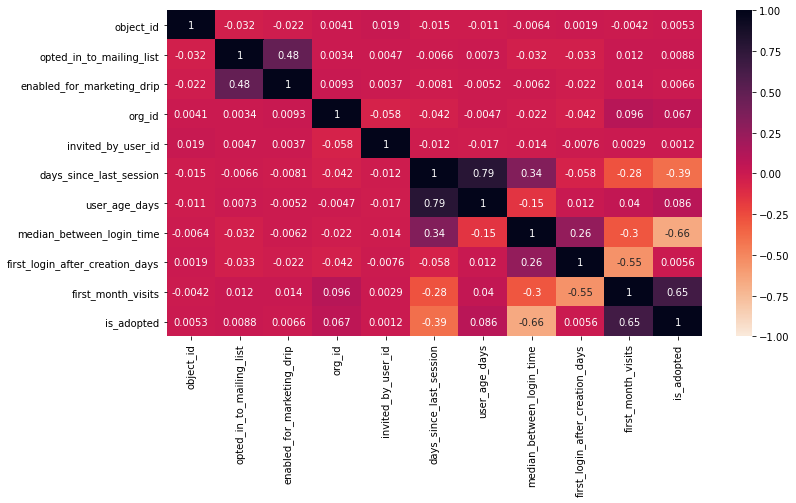

In [33]:
plt.subplots(figsize=(12,6));
sns.heatmap(users_adopt.corr(), vmin=-1, vmax=1, center=0, cmap='rocket_r', annot=True);

<h2> Machine Learning </h2>

Instead of keeping the user_id of the inviter, a new boolean column will be created; 1 representing if a customer was invitied by a user at all. 

In [34]:
users_ml = users_adopt.copy()
users_ml.loc[no_invite.index,'invited_by_user_bool'] = 0
users_ml.loc[by_invite.index,'invited_by_user_bool'] = 1
users_ml.drop(columns=['invited_by_user_id'], inplace=True)

Similarly for the org_id we are going to cluster the organizations into groups and replace org_id with the cluster that the organization is in

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [36]:
org_clustering = users_ml.groupby('org_id').count()[['creation_source']]

In [37]:
avg_silhouette_score = []
inertia = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(org_clustering)
    
    inertia.append(kmeans.inertia_)
    avg_score = silhouette_score(org_clustering, labels)
    avg_silhouette_score.append(avg_score)

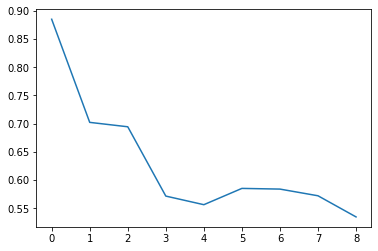

In [38]:
plt.plot(avg_silhouette_score)

The silhouette score recommends that 2 classes be used

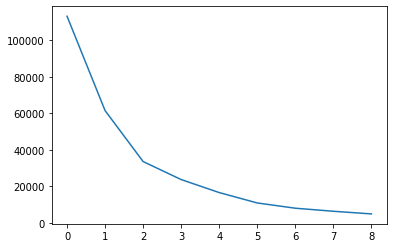

In [39]:
plt.plot(inertia)

The elbow plot recommends 3 classes be used

In [40]:
labels = KMeans(n_clusters=3).fit_predict(org_clustering)

In [41]:
org_clustering['org_clustering'] = labels

In [42]:
users_ml = users_ml.merge(org_clustering['org_clustering'], how='left', left_on='org_id', right_index=True)

In [43]:
users_ml['creation_month'] = users_ml.creation_time.apply(lambda x: x.month)
users_ml['creation_dow'] = users_ml.creation_time.apply(lambda x: x.dayofweek)
users_ml['creation_hour'] = users_ml.creation_time.apply(lambda x: x.hour)

We are going to drop the creation_time column because it has been encoding by month, day of the week, and the hour. Last_session_creation_time because we have the days_since_last_session column. And org_id because we already custered the organization into labels. Although org_id is a numerical column it isn't numerical it is categorical which is the reason for the clustering. 

In [44]:
users_ml.set_index('object_id', inplace=True)
users_ml.drop(columns=['org_id','name','email','creation_time','last_session_creation_time'],inplace=True)

If a user never logged into the platform by X amount of days after creating their account then it is pointless to try to predict future user adoption on them as these users are "too far gone".

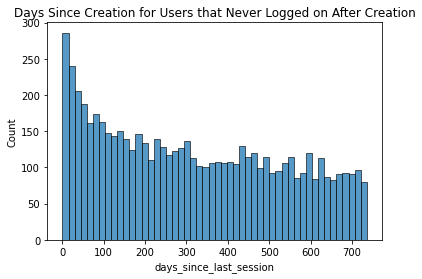

In [45]:
sns.histplot(users_ml[users_ml.first_login_after_creation_days.isna()].days_since_last_session, bins=50);
plt.title('Days Since Creation for Users that Never Logged on After Creation');

To determine what the X cutoff is, let's see how quickly a user makes their first logon after creating the account.

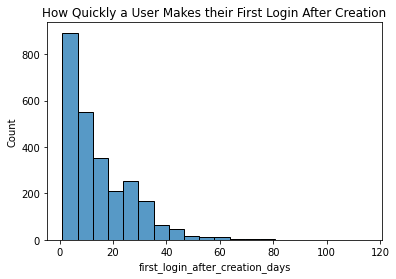

In [46]:
sns.histplot(users_ml[~users_ml.first_login_after_creation_days.isna()].first_login_after_creation_days, bins=20);
plt.title('How Quickly a User Makes their First Login After Creation');

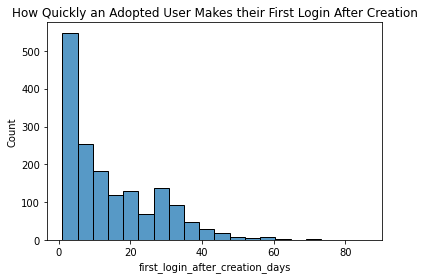

In [47]:
sns.histplot(users_ml[users_ml.is_adopted==1].first_login_after_creation_days, bins=20);
plt.title('How Quickly an Adopted User Makes their First Login After Creation');

Without doing any machine learning we can see that how quickly a user logs in after the creation of their account is could be important future user adoption. We will say that after two months (60 days) if the user doesn't at least login in once after creation then they aren't going to become adopted.

The Dataset Used for Predictions:
<ol>
    <li> Users that are adopted </li>
    <li> Users that already logged in after the creation login within 60 days and aren't already adopted </li>
    <li> Users that haven't logged in after the creation login, but are under 60 days old </li>
</ol>

In [48]:
adopted_users = users_ml[users_ml.is_adopted==1]

In [49]:
first_loginers = users_ml[(users_ml.first_login_after_creation_days < 60) & (users_ml.is_adopted == 0)]

In [50]:
potential_adopted = users_ml[(users_ml.first_login_after_creation_days.isna()) & (users_ml.user_age_days <= 60)]

In [51]:
users_ml = adopted_users.append(first_loginers).append(potential_adopted)

In [52]:
users_ml.first_month_visits.fillna(0, inplace=True)

In [53]:
users_ml.isna().sum()

creation_source                       0
opted_in_to_mailing_list              0
enabled_for_marketing_drip            0
days_since_last_session             432
user_age_days                         0
median_between_login_time          1361
first_login_after_creation_days    1361
first_month_visits                    0
is_adopted                            0
invited_by_user_bool                  0
org_clustering                        0
creation_month                        0
creation_dow                          0
creation_hour                         0
dtype: int64

Missing values will be filled with the maximum value for that column. We are using the max because they are the worst case scenario.

In [54]:
users_ml.days_since_last_session.fillna(users_ml.days_since_last_session.max(), inplace=True)
users_ml.median_between_login_time.fillna(users_ml.median_between_login_time.max(), inplace=True)
users_ml.first_login_after_creation_days.fillna(users_ml.first_login_after_creation_days.max(), inplace=True)

In [55]:
users_ml

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,days_since_last_session,user_age_days,median_between_login_time,first_login_after_creation_days,first_month_visits,is_adopted,invited_by_user_bool,org_clustering,creation_month,creation_dow,creation_hour
object_id,,,,,,,,,,,,,,
2,ORG_INVITE,0,0,67.0,203,8.0,14.0,3.0,1.0,1.0,1,11,4,3
10,ORG_INVITE,1,1,2.0,505,1.0,6.0,6.0,1.0,1.0,0,1,2,22
20,SIGNUP,0,0,8.0,92,2.0,1.0,3.0,1.0,0.0,2,3,3,11
33,GUEST_INVITE,0,0,6.0,87,5.0,6.0,7.0,1.0,1.0,0,3,1,6
42,SIGNUP,1,0,11.0,571,1.0,33.0,1.0,1.0,0.0,0,11,6,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11940,ORG_INVITE,1,0,7.0,7,53.0,86.0,1.0,0.0,1.0,2,5,4,4
11951,ORG_INVITE,0,0,11.0,12,53.0,86.0,1.0,0.0,1.0,2,5,5,15
11978,PERSONAL_PROJECTS,1,0,727.0,43,53.0,86.0,0.0,0.0,0.0,2,4,2,16


In [116]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

In [117]:
users_ml_final = pd.get_dummies(users_ml, drop_first=True)

In [118]:
X = users_ml_final.drop(columns=['is_adopted'])
y = users_ml_final['is_adopted']

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train = np.array(X_train)
y_train = np.array(y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

<h3> Logistic Regression </h3>

In [120]:
cv = StratifiedKFold()
logistic = LogisticRegressionCV(cv=cv)
logistic.fit(X_train,y_train)

LogisticRegressionCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False))

In [121]:
y_pred = logistic.predict(scaler.transform(X_test))

In [122]:
from sklearn.metrics import classification_report

In [123]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       461
         1.0       0.94      0.96      0.95       328

    accuracy                           0.96       789
   macro avg       0.96      0.96      0.96       789
weighted avg       0.96      0.96      0.96       789



A regression coefficient describes the size and direction of the relationship between a predictor and the response variable. Coefficients are the numbers by which the values of the term are multiplied in a regression equation.

In [124]:
pd.DataFrame(data=logistic.coef_,columns=X.columns).T.sort_values(by=0, ascending=False)

,0
user_age_days,11.657222
first_login_after_creation_days,2.493164
first_month_visits,1.782975
org_clustering,0.221319
creation_source_ORG_INVITE,0.179435
creation_source_PERSONAL_PROJECTS,0.158039
creation_source_SIGNUP_GOOGLE_AUTH,0.117653
creation_month,0.092429
enabled_for_marketing_drip,0.036177
creation_source_SIGNUP,-0.011079


The factors that are most positively related to user adoption are:
<ol>
    <li> How old the user is (in days) </li>
    <li> How quickly the user logs in after creating their account </li>
    <li> How many visits they make in their first month </li>
</ol>

The factors that are most negatively related to user adoption are:
<ol>
    <li> How long since the user's last session </li>
    <li> The median time between all of the user's sessions. The longer the time the lest likely user adoption </li>
</ol>
